학습종료후 아래 링크확인해 보기
https://dacon.io/en/codeshare/4245

tar 파일 압축 해제 하기
  - !tar -xvf example.tar.gz

In [ ]:
!tar -xvf /content/drive/MyDrive/이미지세그멘테이션/annotations.tar.gz

In [ ]:
!tar -xvf /content/drive/MyDrive/이미지세그멘테이션/images.tar.gz

In [45]:
# !pip install tensorflow-datasets

In [46]:
# import tensorflow_datasets as tfds

# dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

딥러닝을 이용한 이미지처리
  - 분류
  - 탐지
  - 이미지의 모든 픽셀을 분류하는 이미지 세그멘테이션
    - 인코더_디코더 구조를갖는 대표적인 모델로 U-Net
      - 정보를 복원
      - 압축후 복원하면 원본과 같은 크기인데. 이때 정보는 RGB 가 아니라 클래스에 대한 예측정보

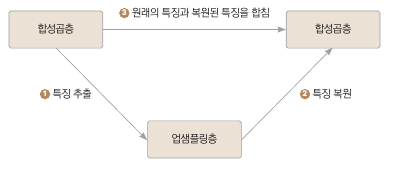

업셈플링 : 특성으로부터 이미지를 복원 또는 키우는 과정

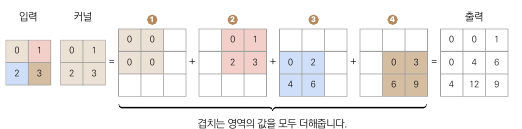

Transposed 합성곱을 이용해서 계산 (전치)
  - 쉽게 애기하면 합성곱을 반대로..

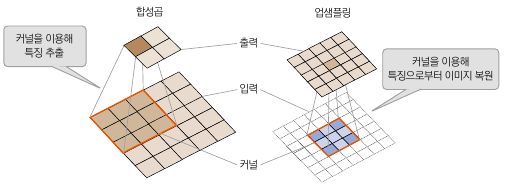

합성곱
  - 특성을 추출하면서 이미지크기가 작아지고 특징추출할때 사용
  - 업셈플링은 이미지 복원

U-net의 단점
  - 인코더와 디코더의 입력을 동일하게 맞춰줘야 해서 설계가 자유롭지 못함
  - 인코더 계산결과를 저장해야해서 메모리가 많이 필요

장점
  - 디코더에서 인코더의 정보를 참조
  - 복원할때 복원대상의 정보를 얻을수 있다

In [3]:
import matplotlib.pyplot as plt
from PIL import Image

In [4]:
import glob
print(len(glob.glob('/content/annotations/trimaps/*.png')))
print(len(glob.glob('/content/images/*.jpg')))

7390
7390


In [28]:
import numpy as np

image_paths = glob.glob('/content/images/*.jpg')
anno_paths = glob.glob('/content/annotations/trimaps/*.png')
image_paths.sort(); anno_paths.sort()
image_paths[:5], anno_paths[:5]

image_lists = [];  anno_lists = []
for idx in range(len(image_paths)):
  img = np.array(Image.open(image_paths[idx]))
  if img.shape[-1] == 3:
    image_lists.append(image_paths[idx])
    anno_lists.append(anno_paths[idx])

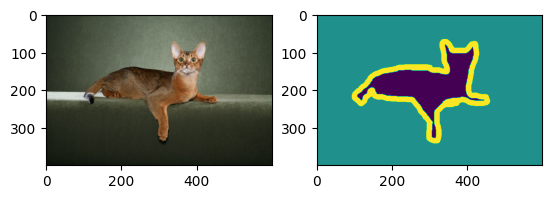

In [29]:
annotation_path = '/content/annotations/trimaps/'
image_path = '/content/images/'

annotation = Image.open(image_lists[0])
plt.subplot(1,2,1)
plt.imshow(annotation)

image = Image.open(anno_lists[0])
plt.subplot(1,2,2)
plt.imshow(image)

데이터셋 만들기

In [30]:
import glob
import torch
import numpy as np

from torch.utils.data.dataset import Dataset
from PIL import Image

class Pets(Dataset):
  def __init__(self,path_to_img, path_to_anno,
               train=True, transforms=None,input_size=(128,128)):
    self.images = sorted(path_to_img)
    self.annotations = sorted(path_to_anno)

    # 학습용과 평가용분리
    split_num = int( len(self.images)*0.8)
    self.x_train = self.images[:split_num]
    self.x_test = self.images[split_num:]
    self.y_train = self.annotations[:split_num]
    self.y_test = self.annotations[split_num:]
    self.train = train
    self.transforms = transforms
    self.input_size = input_size
  def __len__(self):
    if self.train:
      return len(self.x_train)
    else:
      return len(self.x_test)
  def preprocess_mask(self,mask):  #정답을 반환하는 함수  mask PIL객체
    mask = mask.resize(self.input_size)
    mask = np.array(mask).astype(np.float32)
    mask[mask!=2.0] = 1.0
    mask[mask==2.0] = 0.0
    mask = torch.tensor(mask)
    return mask
  def __getitem__(self, index):
    if self.train:
      x_train = Image.open(self.x_train[index])
      x_train = self.transforms(x_train)
      y_train = Image.open(self.y_train[index])
      y_train = self.preprocess_mask(y_train)
      return x_train, y_train
    else:
      x_test = Image.open(self.x_test[index])
      x_test = self.transforms(x_test)
      y_test = Image.open(self.y_test[index])
      y_test = self.preprocess_mask(y_test)
      return x_test, y_test


모델 정의
  - 인코더

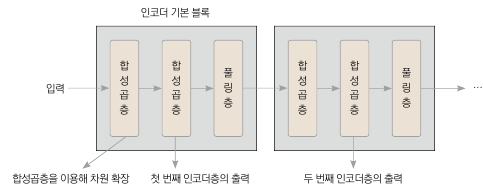

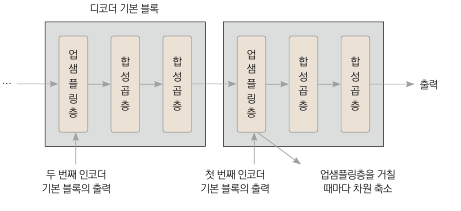

In [31]:
import torch.nn as nn
class Unet(nn.Module):
  def __init__(self):
    super(Unet,self).__init__()
    # 기본블럭
    self.pool = nn.MaxPool2d(kernel_size=2,stride=2)

    self.enc1_1 = nn.Conv2d(3,64,kernel_size=3,padding=1)
    self.enc1_2 = nn.Conv2d(64,64,kernel_size=3,padding=1)

    self.enc2_1 = nn.Conv2d(64,128,kernel_size=3,padding=1)
    self.enc2_2 = nn.Conv2d(128,128,kernel_size=3,padding=1)

    self.enc3_1 = nn.Conv2d(128,256,kernel_size=3,padding=1)
    self.enc3_2 = nn.Conv2d(256,256,kernel_size=3,padding=1)

    self.enc4_1 = nn.Conv2d(256,512,kernel_size=3,padding=1)
    self.enc4_2 = nn.Conv2d(512,512,kernel_size=3,padding=1)

    self.enc5_1 = nn.Conv2d(512,1024,kernel_size=3,padding=1)
    self.enc5_2 = nn.Conv2d(1024,512,kernel_size=3,padding=1)

    # 디코더 은닉층
    self.upsample4 = nn.ConvTranspose2d(512,512,2,stride=2)
    self.dec4_1 = nn.Conv2d(1024,512,kernel_size=3,padding=1)
    self.dec4_2 = nn.Conv2d(512,256,kernel_size=3,padding=1)

    self.upsample3 = nn.ConvTranspose2d(256,256,2,stride=2)
    self.dec3_1 = nn.Conv2d(512,256,kernel_size=3,padding=1)
    self.dec3_2 = nn.Conv2d(256,128,kernel_size=3,padding=1)

    self.upsample2 = nn.ConvTranspose2d(128,128,2,stride=2)
    self.dec2_1 = nn.Conv2d(256,128,kernel_size=3,padding=1)
    self.dec2_2 = nn.Conv2d(128,64,kernel_size=3,padding=1)

    self.upsample1 = nn.ConvTranspose2d(64,64,2,stride=2)
    self.dec1_1 = nn.Conv2d(128,64,kernel_size=3,padding=1)
    self.dec1_2 = nn.Conv2d(64,64,kernel_size=3,padding=1)
    self.dec1_3 = nn.Conv2d(64,1,kernel_size=1)

    self.relu = nn.ReLU() #합성곱과 업샘플링의 활성화 함수
  def forward(self,x):
    # 인코더
    x = self.enc1_1(x)
    x = self.relu(x)
    e1 = self.enc1_2(x)  # 디코더에서 사용
    e1 = self.relu(e1)
    x = self.pool(e1)

    x = self.enc2_1(x)
    x = self.relu(x)
    e2 = self.enc2_2(x)  # 디코더에서 사용
    e2 = self.relu(e2)
    x = self.pool(e2)

    x = self.enc3_1(x)
    x = self.relu(x)
    e3 = self.enc3_2(x)  # 디코더에서 사용
    e3 = self.relu(e3)
    x = self.pool(e3)

    x = self.enc4_1(x)
    x = self.relu(x)
    e4 = self.enc4_2(x)  # 디코더에서 사용
    e4 = self.relu(e4)
    x = self.pool(e4)

    x = self.enc5_1(x)
    x = self.relu(x)
    x = self.enc5_2(x)
    x = self.relu(x)

    # 디코더 forward
    x = self.upsample4(x)
    # 인코더의 출력과 업셈플링된 이미지를 합침
    x = torch.cat([x,e4],dim=1)
    x = self.dec4_1(x)
    x = self.relu(x)
    x = self.dec4_2(x)
    x = self.relu(x)

    x = self.upsample3(x)
    # 인코더의 출력과 업셈플링된 이미지를 합침
    x = torch.cat([x,e3],dim=1)
    x = self.dec3_1(x)
    x = self.relu(x)
    x = self.dec3_2(x)
    x = self.relu(x)

    x = self.upsample2(x)
    # 인코더의 출력과 업셈플링된 이미지를 합침
    x = torch.cat([x,e2],dim=1)
    x = self.dec2_1(x)
    x = self.relu(x)
    x = self.dec2_2(x)
    x = self.relu(x)

    x = self.upsample1(x)
    # 인코더의 출력과 업셈플링된 이미지를 합침
    x = torch.cat([x,e1],dim=1)
    x = self.dec1_1(x)
    x = self.relu(x)
    x = self.dec1_2(x)
    x = self.relu(x)
    x = self.dec1_3(x)

    # 흑백이미지를 그리기위해서 채널을 없앰
    x = torch.squeeze(x)  # 탠서에서 shape 모양의 값중에 1인 차원을 제거
    return x

In [32]:
import tqdm
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor,Resize
from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader
device = "cuda"  if torch.cuda.is_available() else 'cpu'

In [33]:
from torch.utils.data import dataloader
# 데이터 전처리 정의
transform = Compose([
    Resize((128,128)),
    ToTensor()
])
annotation_path = '/content/annotations/trimaps'
image_path = '/content/images'
train_dataset = Pets(path_to_img =image_lists,path_to_anno= anno_lists,transforms=transform)
test_dataset = Pets(path_to_img =image_lists,path_to_anno= anno_lists,transforms=transform, train=False)
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader = DataLoader(test_dataset)

In [ ]:
next(iter(train_dataset))

In [35]:
temp = [data.shape[0] for data,label in train_dataset]

In [36]:
sum(np.array(temp) != 3)

0

In [37]:
next(iter(train_loader))[1].shape

torch.Size([32, 128, 128])

In [38]:
model = Unet().to(device)
lr = 1e-4
optim = Adam(model.parameters(),lr=lr)

nn.BCELoss()
  - 시그모이드를 통과한 확률값
  - 개(0.8912) 고양이(1.10141)
  - torch.max()... np.argmax()

nn.BCEWithLogitsLoss()
  - 개(2.1),고양이(-0.5)  1 : 0
  - 0.810121  > 0.5  1 : 0
  - 쓰레스홀드 0.5  



In [65]:
for epoch in range(10):
  iterdata = tqdm.tqdm(train_loader)
  for data,label in iterdata:
    optim.zero_grad()
    preds = model(data.to(device))
    # loss = nn.BCELoss()(preds,label.to(device)) # 클래스에대한 확률
    loss = nn.BCEWithLogitsLoss()(preds,label.to(device)) # 클래스에 속할 확률  출력을 시그모이드에 적용하기전에 로짓값으로 변환해서적용
    loss.backward()
    optim.step()
    iterdata.set_description(f"epoch:{epoch+1} loss:{loss.item()}")
torch.save(model.state_dict(), 'unet.pth')

epoch:10 loss:0.3222089409828186: 100%|██████████| 185/185 [01:52<00:00,  1.64it/s]


모델 성능 평가

In [66]:
model.load_state_dict(torch.load('unet.pth',map_location='cpu'))

<All keys matched successfully>

In [67]:
test_dataset[0][0].shape, test_dataset[0][1].shape

(torch.Size([3, 128, 128]), torch.Size([128, 128]))

In [68]:
data,label = test_dataset[1]
pred = model(torch.unsqueeze(data.to(device),dim=0)) > 0.5

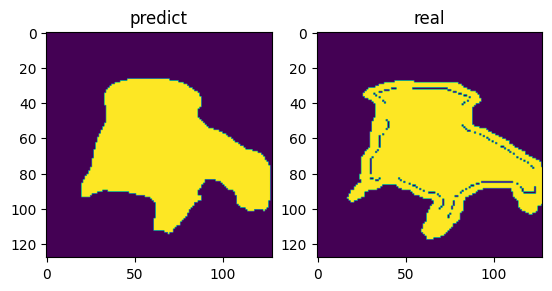

In [69]:
with torch.no_grad():
  plt.subplot(1,2,1)
  plt.title("predict")
  plt.imshow(pred.cpu())
  plt.subplot(1,2,2)
  plt.title("real")
  plt.imshow(label)
  plt.show()